# Model training and predictions 
### Read from file and data cleaning

In [1]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('App').config("spark.driver.memory", "14g").getOrCreate()

In [2]:
print(spark.sparkContext._conf.getAll())

[('spark.driver.port', '34919'), ('spark.app.id', 'local-1607725953581'), ('spark.rdd.compress', 'True'), ('spark.app.name', 'App'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.driver.memory', '14g'), ('spark.driver.host', '192.168.1.75'), ('spark.ui.showConsoleProgress', 'true')]


In [2]:
""" NOTE: If prepared data exists, load it here: 
"""

test_df = spark.read.parquet("test_df")
test_df = test_df.repartition(16)
train_df = spark.read.parquet("train_df")
train_df = train_df.repartition(16)

In [4]:
# File location and type
file_location = "sample_comb1.csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)
df = df.repartition(16)

In [4]:
df.show()

+--------------------+--------------------+-----------------+
|                Body|               Title|              tag|
+--------------------+--------------------+-----------------+
|<p>Are there any ...|Git On Windows Wi...|          windows|
|<p>Is there any w...|How to find diffe...|           c#-4.0|
|<p>Problem: Addre...|address book prog...|                c|
|<p>I'm trying to ...|Reading CDATA XML...|             java|
|<p>I'm a new Ruby...|How to find out w...|    ruby-on-rails|
|<p>right now the ...|Apache only for c...|          apache2|
|<p>I'm currently ...|Why would Chrome ...|internet-explorer|
|<p>What's the sim...|Image a drive in ...|          windows|
|<p>I have two act...|Trouble to publis...|       javascript|
|<p><strong>Are th...|Archive to XML (i...|              ios|
|<p>I'm writing an...|Web app needs to ...|             java|
|<p>It's the magni...|How to implement ...|      objective-c|
|<p>I have written...|How can I improve...|       javascript|
|<p>I'm 

### Indexing tags in both test and train data sets

In [5]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [6]:
df.count()

100267

# Preprocessing 

In [17]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. TODO: Consider wrapping into class below?
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()

def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df

def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


  from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
  # text = remove_punc(text)
  # text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      # if len(word) < 3: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to /home/mklasby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mklasby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
    df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
    df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
    self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
    self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [19]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()

In [20]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.sort(col('count').desc()).show()

+-------------+-----+
|          tag|count|
+-------------+-----+
|           c#| 8711|
|         java| 7631|
|          php| 7296|
|   javascript| 6158|
|      android| 5111|
|          c++| 3632|
|       python| 3338|
|       iphone| 3119|
|       jquery| 3038|
|ruby-on-rails| 1888|
|      asp.net| 1842|
|        mysql| 1572|
|          sql| 1561|
|        linux| 1531|
|            c| 1327|
|         html| 1293|
|         .net| 1257|
|  objective-c| 1248|
|          ios| 1182|
|      windows| 1038|
+-------------+-----+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(('count'))
tag_counts.sort(col('count')).show()

+--------------------+-----+
|                 tag|count|
+--------------------+-----+
|         file-upload|    6|
|              errors|    9|
|           core-data|    9|
|        actionscript|    9|
|            packages|    9|
|   multiple-monitors|    9|
|            iptables|    9|
|equipment-recomme...|   10|
|              domain|   10|
|            notation|   10|
|             freebsd|   11|
|            hyperref|   11|
|           opengl-es|   11|
|              vmware|   11|
|        coding-style|   11|
|functional-progra...|   11|
|                 uml|   11|
|             tridion|   11|
|             process|   11|
|             jenkins|   11|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.sort(col('count').desc()).show()

In [21]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

In [22]:
display(body_counts[:10])

[('0', 111173),
 ('1', 100285),
 ('use', 91487),
 ('2', 54845),
 ('file', 53604),
 ('new', 52662),
 ('get', 52657),
 ('class', 49397),
 ('name', 46951),
 ('code', 45500)]

In [23]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

In [24]:
display(title_counts[:10])

[('use', 9657),
 ('file', 5424),
 ('c', 4869),
 ('get', 4251),
 ('jqueri', 3476),
 ('php', 3405),
 ('error', 3367),
 ('android', 3348),
 ('valu', 3053),
 ('window', 3044)]

### Split test/train sets

In [ ]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df_data.randomSplit(splits, RANDOM_SEED)

In [ ]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

# Machine Learning Data Preparation

### Feature Engineering

In [3]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# FOR LAZY PRE-PROCESSING
  lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
  lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  # FOR TRAD PRE-PROCESSING
  trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
  trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

  lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
  trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
  pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
  pipe_model = pipe.fit(training_data)
  train_df = pipe_model.transform(training_data)  
  test_df = pipe_model.transform(test_data)
  return train_df, test_df

In [13]:
train_df, test_df = feature_engineer()

In [14]:
test_df.select("Trad_Body_Tokens", "trad_features", 'Body').show()

+--------------------+--------------------+--------------------+
|    Trad_Body_Tokens|       trad_features|                Body|
+--------------------+--------------------+--------------------+
|[possibl, duplic,...|(961,[1,3,11,16,1...|<blockquote>
  <p...|
|[possibl, duplic,...|(961,[11,50,94,12...|<blockquote>
  <p...|
|[possibl, duplic,...|(961,[0,2,3,5,9,1...|<blockquote>
  <p...|
|[possibl, duplic,...|(961,[13,27,40,52...|<blockquote>
  <p...|
|[possibl, duplic,...|(961,[1,2,11,14,2...|<blockquote>
  <p...|
|[insur, compani, ...|(961,[0,1,3,6,8,1...|<blockquote>
  <p...|
|[setup, pull, v3,...|(961,[2,3,5,12,13...|<h1>Setup</h1>

<...|
|[background, proo...|(961,[2,3,5,6,8,1...|<h2>Background</h...|
|[would, convert, ...|(961,[0,1,3,5,6,7...|<h2>How would you...|
|[overview, want, ...|(961,[0,1,2,3,4,6...|<h2>Overview</h2>...|
|[get, data, datab...|(961,[6,10,11,12,...|<ol>
<li><p>I get...|
|[1, co, x, xy, si...|(961,[0,1,3,6,35,...|<p>$y''+(1+\cos{x...|
|[problem, field, ...|(96

In [15]:
# write prepared files for further use
test_df.write.parquet("test_df")
train_df.write.parquet("train_df")

# Model Training

## Metrics helper

In [41]:
from pyspark.mllib.evaluation import MulticlassMetrics


def print_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Accuracy = %s" % metrics.accuracy)
    # print("Precision = %s" % precision)
    # print("Recall = %s" % recall)
    # print("F1 Score = %s" % f1Score)
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    if by_tag: 
        # Statistics by class
        labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
        # print(labels)
        for label in sorted(labels):
            try:
                print("Class %s precision = %s" % (label, metrics.precision(label)))
                print("Class %s recall = %s" % (label, metrics.recall(label)))
                print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
            except: 
                print("Class %s not in this set!" % (label))

## Logistic Regression

**Hyperparameter Tuning**

In [22]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.01, 0.1]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx', metricName="accuracy"), 
                          trainRatio=0.9, 
                          seed=0
                         )

lr_grid_search = lr_tvs.fit(train_df)

In [8]:
print('Best Param (regParam): ', lr_grid_search.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', lr_grid_search.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


In [23]:
print('Best Param using accuracy as metric (regParam): ', lr_grid_search.bestModel._java_obj.getRegParam())
print('Best Param using accuracy as metric (elasticNetParam): ', lr_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param using accuracy as metric (fitIntercept): ', lr_grid_search.bestModel._java_obj.getFitIntercept())

Best Param using accuracy as metric (regParam):  0.01
Best Param using accuracy as metric (elasticNetParam):  0.0
Best Param using accuracy as metric (fitIntercept):  False


In [4]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString
from pyspark.mllib.evaluation import MulticlassMetrics

#NOTE: Due to bug with TrainValidationSplit for multiclass classification (see report), this is our "poor man's" grid search. 


def get_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    return metrics


regs = [0, 0.01, 0.1]
elastics = [0, 0.5, 1.0]
intercepts = [False, True]

results = {}

for reg in regs:
    for elastic in elastics: 
        for intercept in intercepts:
            lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=intercept, elasticNetParam=elastic, regParam=reg)
            lr_trad_model = lr_trad.fit(train_df)
            lr_trad_results = lr_trad_model.transform(test_df)
            metrics = get_metrics(lr_trad_results)
            accuracy = metrics.accuracy
            results[(reg, elastic, intercept)] = (metrics.accuracy, metrics.weightedRecall, metrics.weightedPrecision, metrics.weightedFMeasure())
            print(reg, elastic, intercept, " : ",results[(reg, elastic, intercept)])

print(results)

0 0 False  :  (0.3914876530817105, 0.3914876530817111, 0.4029975540102369, 0.3941645269796937)
0 0 True  :  (0.3964063441076089, 0.39640634410760944, 0.42064535807974446, 0.40531376055645263)
0 0.5 False  :  (0.3914876530817105, 0.3914876530817111, 0.4029975540102369, 0.3941645269796937)
0 0.5 True  :  (0.39590443686006827, 0.39590443686006876, 0.42106116299341934, 0.40500564481700285)
0 1.0 False  :  (0.3914876530817105, 0.3914876530817111, 0.4029975540102369, 0.3941645269796937)
0 1.0 True  :  (0.39560329251154386, 0.3956032925115443, 0.4209206579138787, 0.40468611046400044)
0.01 0 False  :  (0.4168841598072676, 0.4168841598072679, 0.5566368440263763, 0.46770775885153343)
0.01 0 True  :  (0.4081509737000602, 0.40815097370006037, 0.6089201456360043, 0.4655762532416954)
0.01 0.5 False  :  (0.3697048785384461, 0.3697048785384461, 0.5625247824870392, 0.4279343129481496)
0.01 0.5 True  :  (0.34721943384862475, 0.34721943384862486, 0.6757417309526611, 0.3794961200011957)
0.01 1.0 False  : 

In [28]:
regParams =[]
elasticNetParams =[]
fitIntercepts =[]
accuracys = []
weightedFMeasures = []
for x in results:
    regParams.append(x[0])
    elasticNetParams.append(x[1])
    fitIntercepts.append(x[2])
    accuracys.append(results[x][0])
    weightedFMeasures.append(results[x][3])

results_lr = {"regParam": regParams, "elasticNetParam": elasticNetParams, "fitIntercept": fitIntercepts, "accuracy": accuracys, "weighted F1": weightedFMeasures}
print(results_lr)

{'regParam': [0, 0, 0, 0, 0, 0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 'elasticNetParam': [0, 0, 0.5, 0.5, 1.0, 1.0, 0, 0, 0.5, 0.5, 1.0, 1.0, 0, 0, 0.5, 0.5, 1.0, 1.0], 'fitIntercept': [False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True, False, True], 'accuracy': [0.3914876530817105, 0.3964063441076089, 0.3914876530817105, 0.39590443686006827, 0.3914876530817105, 0.39560329251154386, 0.4168841598072676, 0.4081509737000602, 0.3697048785384461, 0.34721943384862475, 0.34882553704075486, 0.3227263601686408, 0.3792411162417185, 0.36538847620959647, 0.29512146155390484, 0.2478417988355752, 0.22696245733788395, 0.20939570367396104], 'weighted F1': [0.3941645269796937, 0.40531376055645263, 0.3941645269796937, 0.40500564481700285, 0.3941645269796937, 0.40468611046400044, 0.46770775885153343, 0.4655762532416954, 0.4279343129481496, 0.3794961200011957, 0.4029802086471353, 0.3442884135602253, 0.454675244582442, 0.4336

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results_lr)
df

,regParam,elasticNetParam,fitIntercept,accuracy,weighted F1
0,0.00,0.0,False,0.391488,0.394165
1,0.00,0.0,True,0.396406,0.405314
2,0.00,0.5,False,0.391488,0.394165
3,0.00,0.5,True,0.395904,0.405006
4,0.00,1.0,False,0.391488,0.394165
5,0.00,1.0,True,0.395603,0.404686
6,0.01,0.0,False,0.416884,0.467708
7,0.01,0.0,True,0.408151,0.465576
8,0.01,0.5,False,0.369705,0.427934
9,0.01,0.5,True,0.347219,0.379496


In [ ]:
# NOTE: Best f1 score provided by regParam = 0.01, elasticNet =0, and fitIntercept =False 

In [30]:
df.to_csv("lr_grid_search.csv", index=False)

In [9]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.01, 0.1]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx', metricName="weightedFMeasure"), 
                          trainRatio=0.9, 
                          seed=0
                         )

lr_lazy_grid_search = lr_tvs.fit(train_df)

In [10]:
print('Best Param (regParam): ', lr_lazy_grid_search.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_lazy_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', lr_lazy_grid_search.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


**Model training and transformation of test set**

In [14]:
from pyspark.ml.classification import LogisticRegression
# Lazy model
lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0, regParam=0.01)
lr_lazy_model = lr_lazy.fit(train_df)
lr_lazy_results = lr_lazy_model.transform(test_df)

In [3]:
from pyspark.ml.classification import LogisticRegression
# Trad model
lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0.01)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [15]:
# Lazy metrics
# lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_lazy_results)

Summary Stats
Accuracy = 0.3554507127082915
Weighted recall = 0.3554507127082918
Weighted precision = 0.3615252222637322
Weighted F(1) Score = 0.3556213606964913
Weighted F(0.5) Score = 0.3583344750587261
Weighted false positive rate = 0.016086019272447495


In [13]:
# Lazy metrics
# lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0.01)
print_metrics(lr_lazy_results)

Summary Stats
Accuracy = 0.3952017667135113
Weighted recall = 0.3952017667135114
Weighted precision = 0.5646327932548909
Weighted F(1) Score = 0.45601442986492813
Weighted F(0.5) Score = 0.5131615719144133
Weighted false positive rate = 0.02096136128474486


In [8]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_trad_results)

Summary Stats
Precision = 0.5630936227951153
Recall = 0.5928571428571429
F1 Score = 0.5775922059846903
Weighted recall = 0.3914876530817111
Weighted precision = 0.4029975540102369
Weighted F(1) Score = 0.3941645269796937
Weighted F(0.5) Score = 0.3983669332049998
Weighted false positive rate = 0.015894014632160666


In [17]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0.01)
print_metrics(lr_trad_results)

Summary Stats
Accuracy = 0.4168841598072676
Weighted recall = 0.4168841598072679
Weighted precision = 0.5566368440263763
Weighted F(1) Score = 0.46770775885153343
Weighted F(0.5) Score = 0.5148678225915514
Weighted false positive rate = 0.019741557139978636


## Naive Bayes Classification

**Hyperparameter Tuning**

In [43]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString

nb = NaiveBayes(featuresCol = "trad_features", labelCol = "tag_idx", modelType="multinomial")

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, [0, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 200, 300, 400, 500, 1000]) \
    .build()

nb_tvs = TrainValidationSplit(estimator=nb, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx', metricName="accuracy"), 
                          trainRatio=0.9, 
                          seed=0
                         )

nb_grid_search = nb_tvs.fit(train_df)

In [44]:
print('Best Param (smoothing): ', nb_grid_search.bestModel._java_obj.getSmoothing())

Best Param (smoothing):  100.0


In [35]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.evaluation import MulticlassMetrics

#NOTE: Due to bug with TrainValidationSplit for multiclass classification (see report), this is our "poor man's" grid search. 


def get_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    return metrics


smoothing = [0, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 200, 300, 400, 500, 1000]
results = {}

for smooth in smoothing:
    nb_trad = NaiveBayes(featuresCol = "trad_features", labelCol = "tag_idx", modelType="multinomial", smoothing=smooth)
    nb_trad_model = nb_trad.fit(train_df)
    nb_trad_result = nb_trad_model.transform(test_df)
    metrics = get_metrics(nb_trad_result)
    accuracy = metrics.accuracy
    results[smooth] = (metrics.accuracy, metrics.weightedRecall, metrics.weightedPrecision, metrics.weightedFMeasure())
    print(smooth, " : ",results[smooth])

print(results)

0  :  (0.32383055611323025, 0.3238305561132307, 0.3463143851150841, 0.3098032512984989)
0.01  :  (0.3155992772535635, 0.3155992772535638, 0.3319218334140634, 0.29275590283759495)
0.1  :  (0.2965268018470187, 0.2965268018470189, 0.30228086793718756, 0.26597532699143006)
0.5  :  (0.2815699658703072, 0.2815699658703074, 0.28322286051542733, 0.24655243018840328)
1.0  :  (0.2860871310981731, 0.28608713109817335, 0.3023176037307148, 0.25461019888932535)
10.0  :  (0.3434049387673158, 0.3434049387673159, 0.4305233441979294, 0.34413286097831003)
100.0  :  (0.36829953824533224, 0.3682995382453324, 0.5649227094962774, 0.4313861730967078)
200  :  (0.3575587231479623, 0.35755872314796233, 0.6175790972147132, 0.4363998713013578)
300  :  (0.3423007428227264, 0.34230074282272643, 0.6442425558491498, 0.42569005986443365)
400  :  (0.33125878337683196, 0.33125878337683196, 0.6622154087478967, 0.4159562839352264)
500  :  (0.3199156795824132, 0.3199156795824131, 0.6720459295687307, 0.40581783455764336)
100

In [37]:
smoothing =[]
accuracys =[]
weightedFMeasures = []
for x in results:
    smoothing.append(x)
    accuracys.append(results[x][0])
    weightedFMeasures.append(results[x][3])

results_nb = {"smoothing": smoothing, "accuracy": accuracys, "weighted F1": weightedFMeasures}
print(results_nb)

{'smoothing': [0, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 200, 300, 400, 500, 1000], 'accuracy': [0.32383055611323025, 0.3155992772535635, 0.2965268018470187, 0.2815699658703072, 0.2860871310981731, 0.3434049387673158, 0.36829953824533224, 0.3575587231479623, 0.3423007428227264, 0.33125878337683196, 0.3199156795824132, 0.28859666733587636], 'weighted F1': [0.3098032512984989, 0.29275590283759495, 0.26597532699143006, 0.24655243018840328, 0.25461019888932535, 0.34413286097831003, 0.4313861730967078, 0.4363998713013578, 0.42569005986443365, 0.4159562839352264, 0.40581783455764336, 0.37788653085170665]}


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results_nb)
df.to_csv("nb_grid_search_results.csv", index=False)
df

,smoothing,accuracy,weighted F1
0,0.00,0.323831,0.309803
1,0.01,0.315599,0.292756
2,0.10,0.296527,0.265975
3,0.50,0.281570,0.246552
4,1.00,0.286087,0.254610
5,10.00,0.343405,0.344133
6,100.00,0.368300,0.431386
7,200.00,0.357559,0.436400
8,300.00,0.342301,0.425690
9,400.00,0.331259,0.415956


In [ ]:
# NOTE: Best F1 score given by smoothing=200

**Model training and transformation of test set**

In [6]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString


# Lazy Model
# TODO: Select best hyper parameters
nb_lazy = NaiveBayes(featuresCol = "lazy_features", labelCol = "tag_idx", modelType="multinomial", smoothing=100)
nb_lazy_model = nb_lazy.fit(train_df)
nb_lazy_result = nb_lazy_model.transform(test_df)

In [40]:
# Trad Model
# TODO: Select best hyper parameters
nb_trad = NaiveBayes(featuresCol = "trad_features", labelCol = "tag_idx", modelType="multinomial", smoothing=200)
nb_trad_model = nb_trad.fit(train_df)
nb_trad_result = nb_trad_model.transform(test_df)

**Performance Metrics**

In [8]:
# Lazy Metrics - 0.01
print_metrics(nb_lazy_result)

Summary Stats
Accuracy = 0.2904035334270227
Weighted recall = 0.2904035334270231
Weighted precision = 0.294929738241489
Weighted F(1) Score = 0.26204087792428005
Weighted F(0.5) Score = 0.26899500686179684
Weighted false positive rate = 0.013301320247463153


In [12]:
# Lazy Metrics - 100
print_metrics(nb_lazy_result)

Summary Stats
Accuracy = 0.3155992772535635
Weighted recall = 0.31559927725356357
Weighted precision = 0.6037756260051368
Weighted F(1) Score = 0.3909335054981676
Weighted F(0.5) Score = 0.4861475876206243
Weighted false positive rate = 0.025666137322996524


In [7]:
# Lazy Metrics - 200
print_metrics(nb_lazy_result)

Summary Stats
Accuracy = 0.2799638626781771
Weighted recall = 0.2799638626781771
Weighted precision = 0.6772692634089034
Weighted F(1) Score = 0.3582257302206183
Weighted F(0.5) Score = 0.4818614376726144
Weighted false positive rate = 0.02846641934322268


In [9]:
# Trad Metrics - 0.01
print_metrics(nb_trad_result)

Summary Stats
Accuracy = 0.3155992772535635
Weighted recall = 0.3155992772535638
Weighted precision = 0.3319218334140634
Weighted F(1) Score = 0.29275590283759495
Weighted F(0.5) Score = 0.3037705797750916
Weighted false positive rate = 0.013468969590006947


In [9]:
# Trad Metrics - 100
print_metrics(nb_trad_result)

Summary Stats
Accuracy = 0.36829953824533224
Weighted recall = 0.3682995382453324
Weighted precision = 0.5649227094962774
Weighted F(1) Score = 0.4313861730967078
Weighted F(0.5) Score = 0.49815701767390497
Weighted false positive rate = 0.021421501819461657


In [42]:
# Trad Metrics - 200
print_metrics(nb_trad_result)

Summary Stats
Accuracy = 0.3575587231479623
Weighted recall = 0.35755872314796233
Weighted precision = 0.6175790972147132
Weighted F(1) Score = 0.4363998713013578
Weighted F(0.5) Score = 0.523349829674784
Weighted false positive rate = 0.022732366420350775


##Random Forest

**Hyperparameter Tuning**

In [18]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10,15]) \
    .addGrid(rf.maxDepth, [10,15,20])\
    .build()

rf_tvs = TrainValidationSplit(estimator=rf, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9
                         )
rf_grid_search = rf_tvs.fit(train_df)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 48206)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
ERROR:py4j.java_gateway:An error occurre

Py4JError: An error occurred while calling o1487.fit

In [ ]:
print('Best Param (regParam): ', rf_grid_search.bestModel._java_obj.getNumTrees())
print('Best Param (elasticNetParam): ', rf_grid_search.bestModel._java_obj.getMaxDepth())

**Model training and transformation of test set**

In [5]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier

#Lazy Model
# TODO: Select best hyper parameters
rf_lazy = RandomForestClassifier(featuresCol = "lazy_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_model_lazy = rf_lazy.fit(train_df)
rf_lazy_results = rf_model_lazy.transform(test_df)

In [4]:
from pyspark.ml.classification import RandomForestClassifier
# Trad Model
# TODO: Select best hyper parameters
rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=20, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [6]:
# Lazy Metrics 15x15
print_metrics(rf_lazy_results)

Summary Stats
Precision = 0.5549525101763908
Recall = 0.6206373292867982
F1 Score = 0.5859598853868195
Weighted recall = 0.3617747440273038
Weighted precision = 0.7275010126870887
Weighted F(1) Score = 0.40769649660693535
Weighted F(0.5) Score = 0.5043217800967325
Weighted false positive rate = 0.023526884861624575


In [29]:
# Trad Metrics 5x10

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Weighted recall = 0.3142943184099578
Weighted precision = 0.8061594711014445
Weighted F(1) Score = 0.3688232949162735
Weighted F(0.5) Score = 0.4882415650825658
Weighted false positive rate = 0.023236140428347186


In [7]:
# Trad Metrics 10 x 10
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Weighted recall = 0.36649267215418596
Weighted precision = 0.7432159825234219
Weighted F(1) Score = 0.42620508964566167
Weighted F(0.5) Score = 0.5292808057039928
Weighted false positive rate = 0.02342937916416189


In [9]:
# Trad Metrics 15 x 15
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Weighted recall = 0.38968078699056424
Weighted precision = 0.7529701187026079
Weighted F(1) Score = 0.4475235540447458
Weighted F(0.5) Score = 0.5501515841010801
Weighted false positive rate = 0.019257526319745113


In [7]:
# Trad Metrics 20 depth x 15 trees
print_metrics(rf_trad_result)

Summary Stats
Precision = 0.6567164179104478
Recall = 0.5902439024390244
F1 Score = 0.621708413615928
Weighted recall = 0.40413571571973517
Weighted precision = 0.7207090119630157
Weighted F(1) Score = 0.4656150050476798
Weighted F(0.5) Score = 0.5598040633638067
Weighted false positive rate = 0.020090089368159765


##SVC + OVR
Due to limited nodes included in the databricks community edition, we were unable to fit a one-vs-rest model with a support-vector-classifier in under 3 hours. Therefore, we recommend future researchers consider investing is a full fledged account to test this model type on large datasets.

In [18]:
# Do not run!
# TESTED OVER NIGHT, DID NOT COMPLETE FIT IN MORE THAN 12 HOURS
from pyspark.ml.classification import LinearSVC, OneVsRest
svc = LinearSVC(featuresCol = "trad_features", labelCol = "tag_idx")
ovr = OneVsRest(featuresCol = "trad_features", labelCol = "tag_idx",  classifier= svc)
ovrModel = ovr.fit(train_df)
svc_result = ovrModel.transform(test_df)

KeyboardInterrupt: 

In [ ]:
# Trad Metrics

#Get labels/predictions in RDD expected by metrics classes
svc_trad_labels_and_predictions = svc_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
svc_trad_metrics = MulticlassMetrics(svc_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % svc_trad_metrics.weightedRecall)
print("Weighted precision = %s" % svc_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % svc_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % svc_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % svc_trad_metrics.weightedFalsePositiveRate)

# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [4]:
# TODO: Update with best performing model 
top_df = lr_trad_results
top_df.show()

+--------------------+--------------------+-----------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Body|               Title|              tag|tag_idx|   Lazy_Title_Tokens|    Lazy_Body_Tokens|   Trad_Title_Tokens|    Trad_Body_Tokens|    lazy_body_vector|   lazy_title_vector|       lazy_features|    trad_body_vector|   trad_title_vector|       trad_features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|

In [5]:
# write prepared file for further use
top_df.write.parquet("top_df_lr")

In [6]:
top_df = spark.read.parquet("top_df_lr")
top_df.cache()
top_df.count()

9962

In [7]:
from pyspark.ml.feature import IndexToString
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer
decoder = IndexToString(inputCol="prediction", outputCol="predicted_tag", labels=tag_encode.labels)
top_df = decoder.transform(top_df)
top_df.select(["tag", "tag_idx", "prediction", "predicted_tag"]).show()

+--------------------+-------+----------+-------------+
|                 tag|tag_idx|prediction|predicted_tag|
+--------------------+-------+----------+-------------+
|              jquery|    8.0|       8.0|       jquery|
|              vb.net|   28.0|      16.0|         .net|
|                  c#|    0.0|       0.0|           c#|
|                  c#|    0.0|       0.0|           c#|
|                java|    1.0|       1.0|         java|
|             windows|   19.0|      19.0|      windows|
|               cocoa|   89.0|      18.0|          ios|
|              ubuntu|   40.0|      13.0|        linux|
|           amazon-s3|  317.0|       2.0|          php|
|sequences-and-series|  136.0|      42.0|    algorithm|
|                 c++|    5.0|       1.0|         java|
|                java|    1.0|       1.0|         java|
|              macosx|  315.0|       0.0|           c#|
|              jquery|    8.0|       3.0|   javascript|
|              iphone|    7.0|       7.0|       

In [8]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
from pyspark.sql.functions import desc, col

def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df

    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of

    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    #get dict of labels to plot
    label_metrics = {}

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)

    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}

    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]

    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)

    # Get overall tag counts from input DF
    tag_counts = train_df.select('tag').groupby('tag').count().sort(desc('count')).collect()
    tag_counts = {x['tag']: x['count'] for x in tag_counts}

    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    tag_count_list = []

    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])
        tag_count_list.append(tag_counts[tag])

    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list, "Count":tag_count_list})
    
    return plot_df

In [9]:
plot_df = get_label_metrics(top_df)
print(plot_df)

                      Tag  F1Measure  Precision    Recall  Count
0                  python   0.676880   0.698276  0.656757   2990
1                 android   0.670711   0.751456  0.605634   4596
2           ruby-on-rails   0.651163   0.656250  0.646154   1696
3                   mysql   0.646154   0.656250  0.636364   1412
4                     php   0.573151   0.707713  0.481584   6557
..                    ...        ...        ...       ...    ...
453                winapi   0.000000   0.000000  0.000000     47
454               haskell   0.000000   0.000000  0.000000    131
455        iphone-sdk-4.0   0.000000   0.000000  0.000000     16
456       custom-taxonomy   0.000000   0.000000  0.000000     22
457  discrete-mathematics   0.000000   0.000000  0.000000     14

[458 rows x 5 columns]


In [10]:
bottom_10 = plot_df.sort_values("Count", ascending=False).head(10)
print(bottom_10)

              Tag  F1Measure  Precision    Recall  Count
14             c#   0.447615   0.651366  0.340961   7796
11           java   0.490959   0.607870  0.411765   6894
4             php   0.573151   0.707713  0.481584   6557
8      javascript   0.532292   0.635593  0.457875   5568
1         android   0.670711   0.751456  0.605634   4596
10            c++   0.495261   0.558824  0.444681   3258
0          python   0.676880   0.698276  0.656757   2990
7          iphone   0.532967   0.617834  0.468599   2805
5          jquery   0.559028   0.559028  0.559028   2750
2   ruby-on-rails   0.651163   0.656250  0.646154   1696


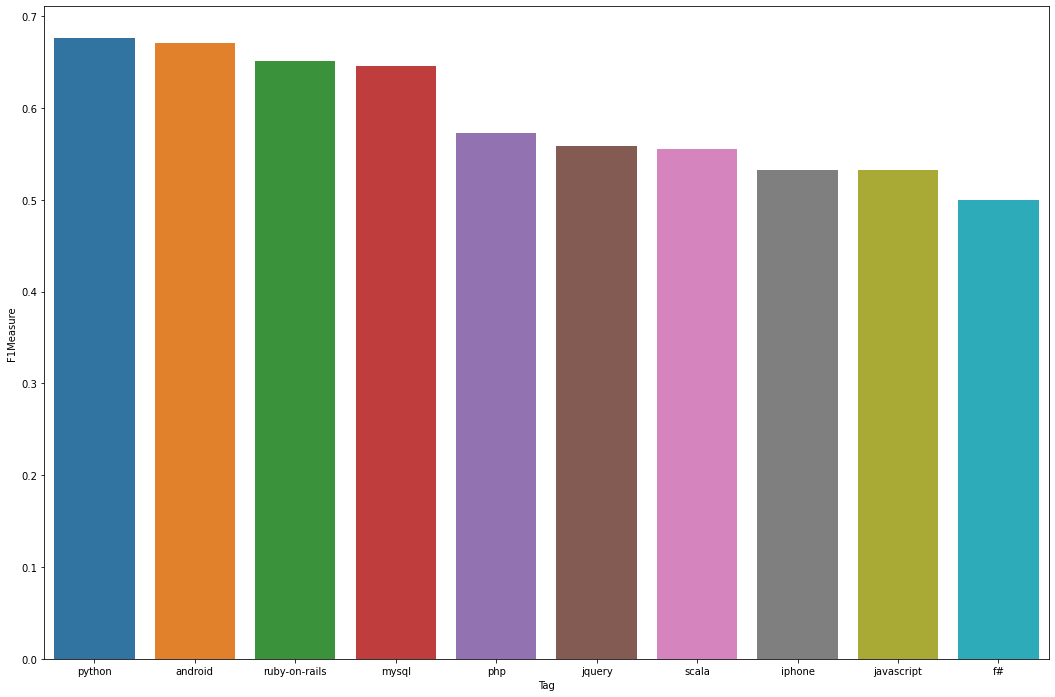

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df[:10], ax=ax)
fig.show()
# TODO: Update file name 
plt.savefig("Tag1_top10_f1")

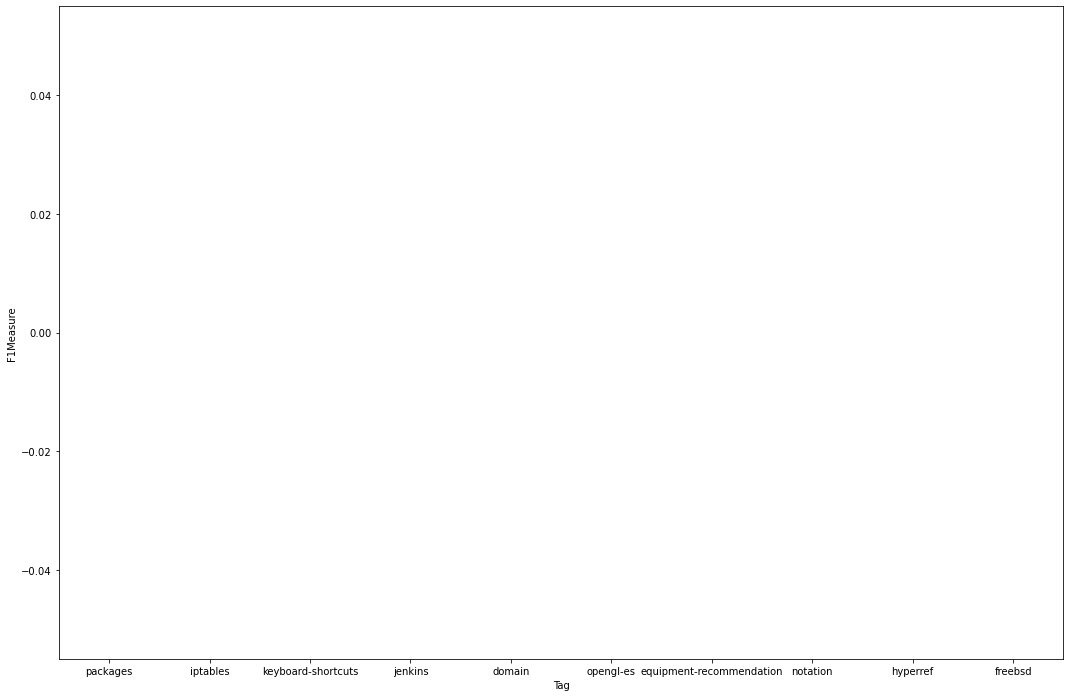

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag1_bottom10_f1")

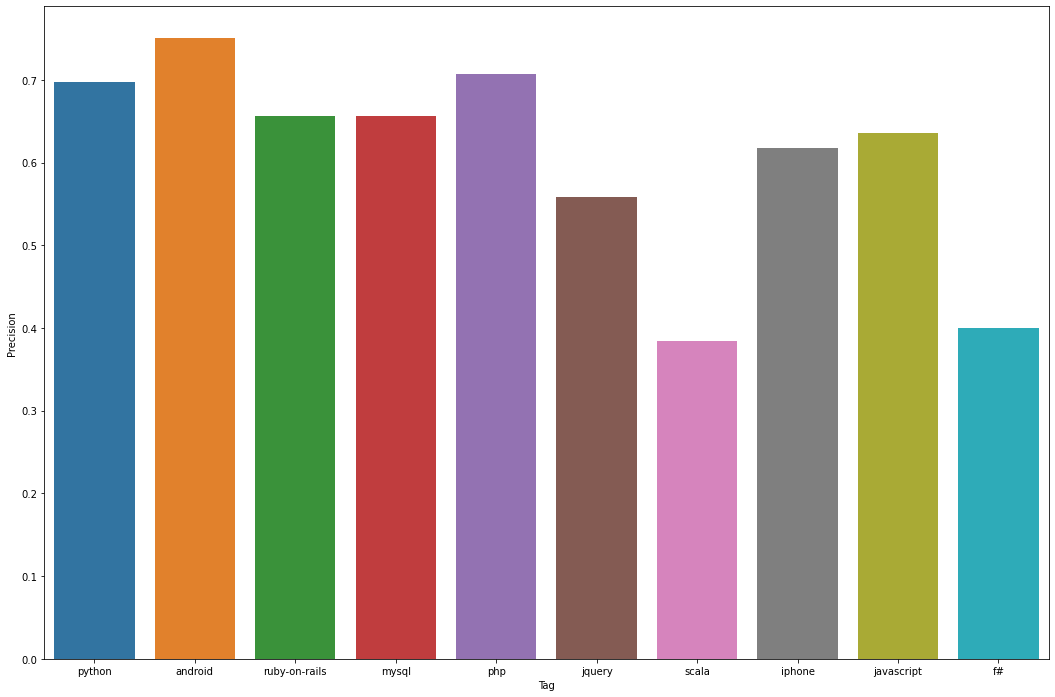

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag1_top10_prec")

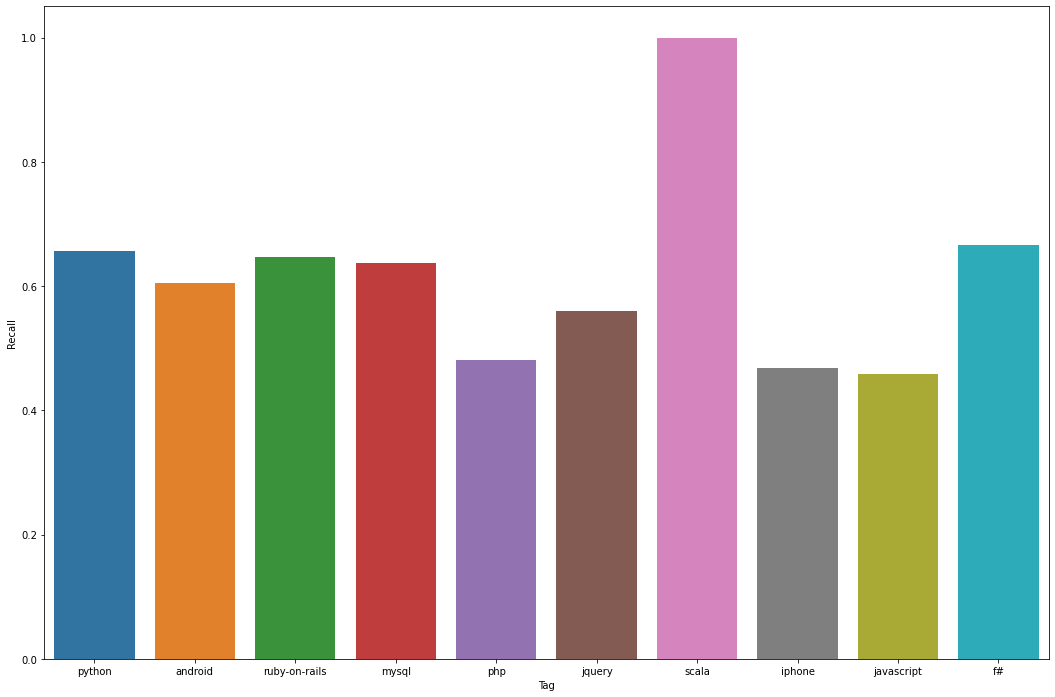

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag1_top10_recall")

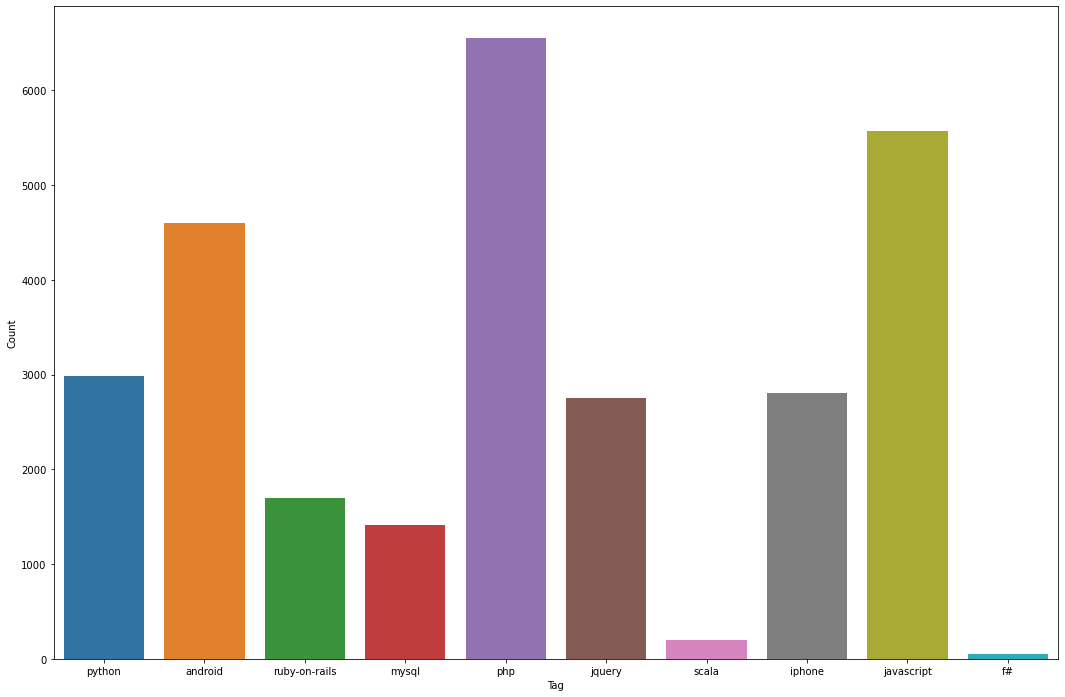

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag1_top10_count")

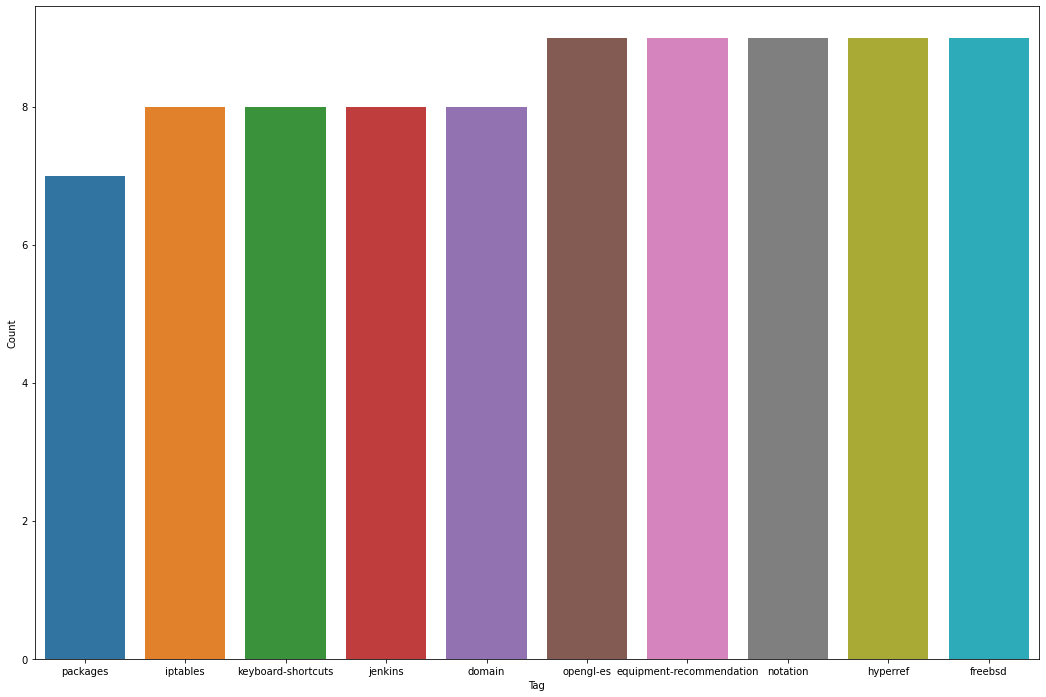

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag1_bottom10_count")

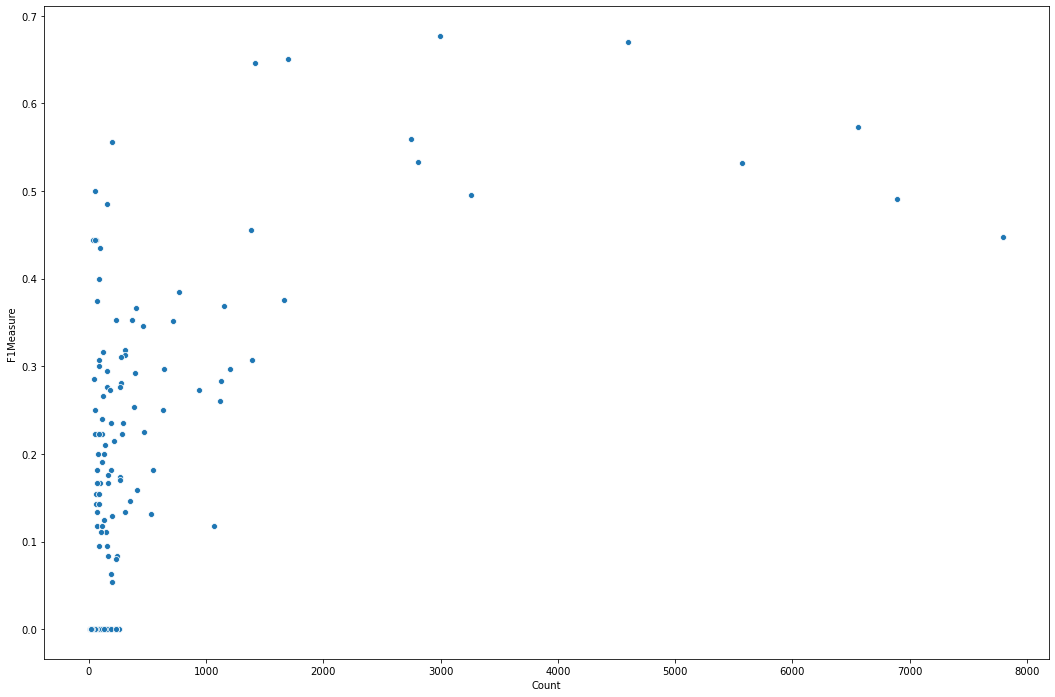

In [21]:
# Counts vs F1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.scatterplot(x="Count", y="F1Measure", data=plot_df, ax=ax)
fig.show()
plt.savefig("Tag 1 F1Measure vs Count")

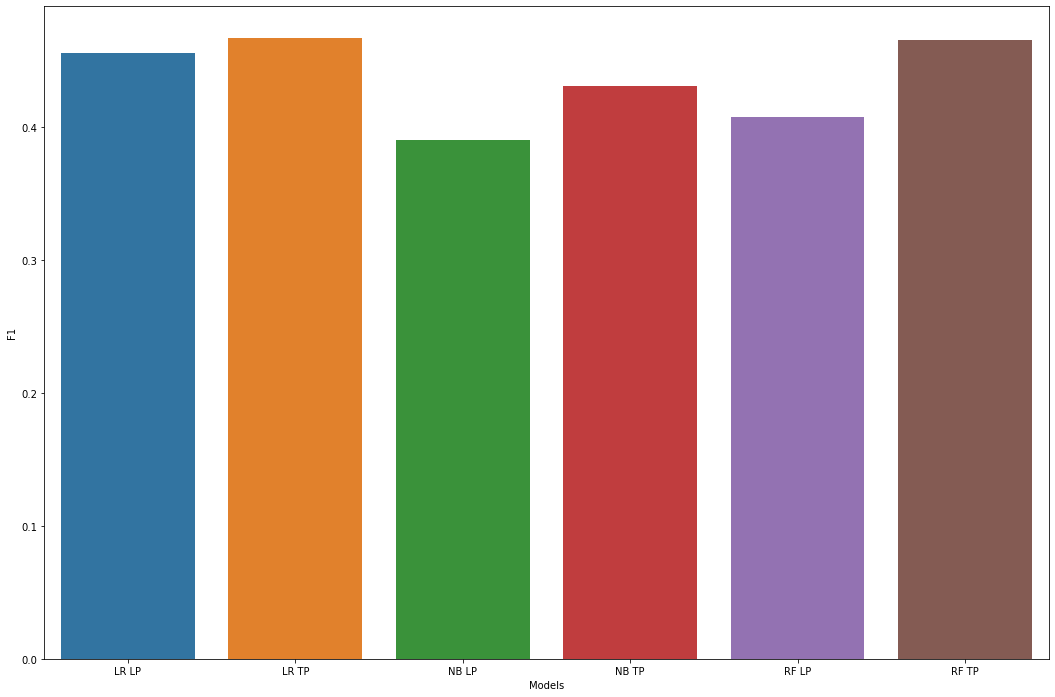

In [22]:
# F1 Weighted Results 
# TODO: Update weighted f1 scores below 

lr_lazy = 0.45601442986492813
lr_trad = 0.46770775885153343
nb_lazy = 0.3909335054981676
nb_trad = 0.4313861730967078
rf_lazy= 0.40769649660693535
rf_trad = 0.4656150050476798
this_dict = {'Models': ["LR LP","LR TP", "NB LP", "NB TP", "RF LP", "RF TP"], "F1": [lr_lazy, lr_trad, nb_lazy, nb_trad, rf_lazy,rf_trad]}

seaborn_df = pd.DataFrame.from_dict(this_dict)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Models", y="F1", data=seaborn_df, ax =ax)
fig.show()
plt.savefig("Tag1_model_performance")